# Deep Learning aplicado à análise de imagens de mamografia
### Base de dados: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629 

In [1]:
from itertools import product

#system related
import time
from pathlib import Path 
import warnings

#data manipulation / preparation
import numpy as np
import pandas as pd
import json

#image manipulation
import pydicom as dicom
from skimage import draw, transform
from skimage.transform import resize
from skimage.color import gray2rgb

#model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LeakyReLU, Conv2D, Activation, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout,InputLayer, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import SGD, Adam

#metrics
from sklearn import metrics

#plotting
import matplotlib.pylab as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

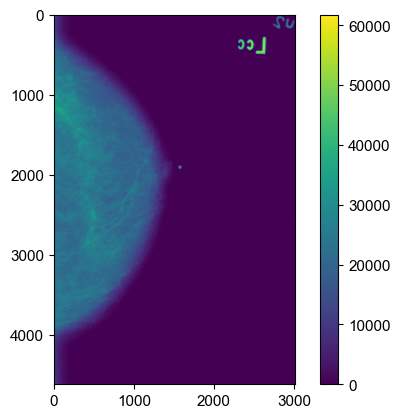

In [2]:
#Abrindo uma imagem dicom a partir de um caminho específico
image_path = r'C:\Users\dsrre\Documents\TCC MBA\4.10 Reconhecimento de imagem\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-2017-DDSM-NA-96009\1.000000-full mammogram images-63992\1-1.dcm'
ds = dicom.dcmread(image_path)
plt.rc('font', family = 'Arial', size = 11)
plt.imshow(ds.pixel_array)
plt.colorbar()

In [3]:
#Carregando conjunto de treino para calc
calc_train_df = pd.read_csv("calc_case_description_train_set.csv")

#Carregando conjunto de test para calc
calc_test_df = pd.read_csv("calc_case_description_test_set.csv")

#Carregando conjunto de treino para mass
mass_train_df = pd.read_csv("mass_case_description_train_set.csv")

#Carregando conjunto de teste para mass
mass_test_df = pd.read_csv("mass_case_description_test_set.csv")

In [4]:
calc_train_df.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [5]:
#Removendo linhas contendo elementos nulos
calc_te = calc_test_df.dropna()

calc_tr = calc_train_df.dropna()

mass_te = mass_test_df.dropna()

mass_tr = mass_train_df.dropna()

In [6]:
#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
calc_tr = calc_tr[calc_tr.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
calc_te = calc_te[calc_te.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
mass_tr = mass_tr[mass_tr.pathology != 'BENIGN_WITHOUT_CALLBACK']

#Criando novo dataframe excluindo-se as linhas da coluna 'pathology' com valores iguais a 'BENIGN_WITHOUT_CALLBACK'
mass_te = mass_te[mass_te.pathology != 'BENIGN_WITHOUT_CALLBACK']

In [7]:
#0 = ausência de câncer; 1 = presença de câncer
calc_tr['pathology'] = calc_tr['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
calc_te['pathology'] = calc_te['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
mass_tr['pathology'] = mass_tr['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])
mass_te['pathology'] = mass_te['pathology'].replace(['BENIGN','MALIGNANT'], [0,1])

In [8]:
''' Unindo 4 dataframes em um só em etapas sucessivas pois não é possível unir mais de 2 simultaneamente.
    Esse procedimento é para possibilitar a criação de uma lista posteriormente, facilitando a futura
    criação de um dicionário contendo ids e paths. '''
mam = pd.merge(calc_te, calc_tr, how = 'outer')
mamm = pd.merge(mam, mass_te, how = 'outer')
mammography = pd.merge(mamm, mass_tr, how = 'outer')
mammography.head(10)

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038             2.0                 LEFT         CC               1   
1    P_00038             2.0                 LEFT        MLO               1   
2    P_00100             4.0                RIGHT         CC               1   
3    P_00100             4.0                RIGHT        MLO               1   
4    P_00127             2.0                RIGHT         CC               1   
5    P_00127             2.0                RIGHT        MLO               1   
6    P_00132             4.0                 LEFT        MLO               1   
7    P_00141             1.0                 LEFT         CC               1   
8    P_00141             1.0                 LEFT        MLO               1   
9    P_00150             3.0                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification           PLEOMORPHIC         CLUSTERED           4   
3    calcification           PLEOMORPHIC         CLUSTERED           4   
4    calcification           PLEOMORPHIC         CLUSTERED           4   
5    calcification           PLEOMORPHIC         CLUSTERED           4   
6    calcification             AMORPHOUS         SEGMENTAL           4   
7    calcification             AMORPHOUS         CLUSTERED           4   
8    calcification             AMORPHOUS         CLUSTERED           4   
9    calcification           PLEOMORPHIC         CLUSTERED           4   

   pathology  subtlety                                    image file path  \
0          0         2  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1          0         2  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2          0         4  Calc-Test_P_00100_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3          0         4  Calc-Test_P_00100_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
4          1         3  Calc-Test_P_00127_RIGHT_CC/1.3.6.1.4.1.9590.10...   
5          1         3  Calc-Test_P_00127_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
6          0         2  Calc-Test_P_00132_LEFT_MLO/1.3.6.1.4.1.9590.10...   
7          0         2  Calc-Test_P_00141_LEFT_CC/1.3.6.1.4.1.9590.100...   
8          0         2  Calc-Test_P_00141_LEFT_MLO/1.3.6.1.4.1.9590.10...   
9          1         2  Calc-Test_P_00150_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped image file path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Calc-Test_P_00100_RIGHT_CC_1/1.3.6.1.4.1.9590....   
3  Calc-Test_P_00100_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
4  Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590....   
5  Calc-Test_P_00127_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
6  Calc-Test_P_00132_LEFT_MLO_1/1.3.6.1.4.1.9590....   
7  Calc-Test_P_00141_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
8  Calc-Test_P_00141_LEFT_MLO_1/1.3.6.1.4.1.9590....   
9  Calc-Test_P_00150_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                  ROI mask file path  breast_density  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...             NaN   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....             NaN   
2  Calc-Test_P_00100_RIGHT_CC_1/1.3.6.1.4.1.9590....             NaN   
3  Calc-Test_P_00100_RIGHT_MLO_1/1.3.6.1.4.1.9590...             NaN   
4  Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590....             NaN   
5  Calc-Test_P_00127_RIGHT_MLO_1/1.3.6.1.4.1.9590...             NaN   
6  Calc-Test_P_00132_LEFT_MLO_1/1.3.6.1.4.1.9590....             NaN   
7  Calc-Test_P_00141_LEFT_CC_1/1.3.6.1.4.1.9590.1...             NaN   
8  Calc-Test_P_00141_LEFT_MLO_1/1.3.6.1.4.1.9590....             NaN   
9  Calc-Test_P_00150_RIGHT_MLO_1/1.3.6.1.4.1.9590...             NaN   

  mass shape mass margins  
0        NaN        

In [9]:
print(len(mammography))

2856


In [10]:
mammography.columns

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path', 'breast_density',
       'mass shape', 'mass margins'],
      dtype='object')

In [11]:
path_list = mammography['ROI mask file path'].tolist()

In [12]:
subs = []
for path in path_list:
    subs.append(path.split("/"))  

In [13]:
paths = []
for elem in subs:
    paths.append(elem[0])

In [14]:
dir_origin = Path(r'C:\Users\dsrre\Documents\TCC MBA\4.10 Reconhecimento de imagem\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM')

all_images = []
def scan_folder(parent):
    ''' Esta função percorre subpastas presentes em um diretório em busca de arquivos com extensão .dcm.
        Parâmetro: diretório pai.
    '''
    for file_path in parent.iterdir():  # Objetos pathlib.Path tem o método "iterdir"
        if file_path.suffix == ".dcm":  # e tem o atributo ".suffix" que é a extensão do arquivo, incluindo o "."
#            print(file_path)    
            all_images.append(file_path)
        elif file_path.is_dir():  # e tem o método "is_dir" pra saber se o objeto é um diretório
            # current_path = "".join((parent, "/", file_name))  # < não precisa deesse passo, já estamos "vendo" o caminho completo para o novo diretório
            scan_folder(file_path)        
    return

scan_folder(dir_origin)
#print(all_images)

In [15]:
image_list = []
for _ in all_images:
    image_list.append(r'{}'.format(str(_)))

In [16]:
''' Criando dicionário onde as ids são as chaves e os paths os valores. Isso é feito para filtrar as imagens a serem
    treinadas na rede. '''
dict_images = {id: list(elem for elem in image_list if id in elem) for id in paths}
#print(json.dumps(dict_images, indent=4))  

In [17]:
resultlist = list(dict_images.values())
#print(resultlist)

In [18]:
img_dcm = []
for elem in resultlist:
    img_dcm.append(elem[0])

In [19]:
path_calc_test = img_dcm[0:257]
path_calc_train = img_dcm[257:1322]
path_mass_test = img_dcm[1322:1660]
path_mass_train = img_dcm[1660:2856]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.91213196712083108437372207623997094496
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.91213196712083108437372207623997094496
(0008, 0020) Study Date                          DA: '20170830'
(0008, 0023) Content Dat

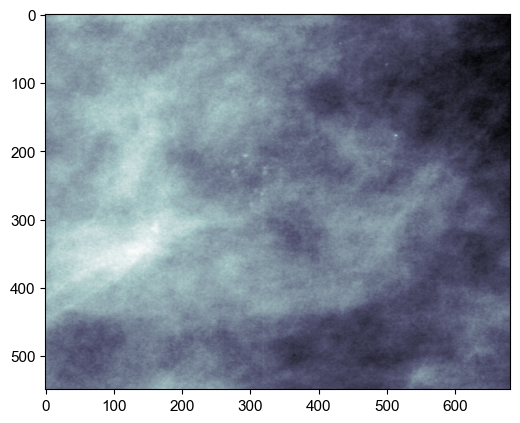

In [20]:
image_path = path_calc_train[1]
ctrain = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctrain.pixel_array, cmap="bone")
#.colorbar()

print(ctrain)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.221048975511600000511711276821233467837
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.221048975511600000511711276821233467837
(0008, 0020) Study Date                          DA: '20170830'
(0008, 0023) Content D

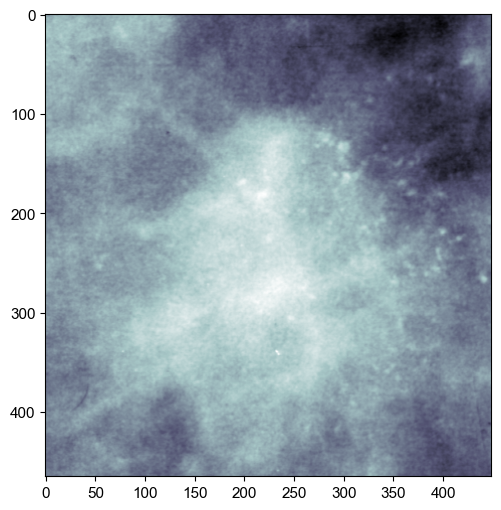

In [21]:
image_path = path_calc_train[12]
ctrain2 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctrain2.pixel_array, cmap="bone")
#plt.colorbar()

print(ctrain2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.252803614412496646010439133973466706788
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.252803614412496646010439133973466706788
(0008, 0020) Study Date                          DA: '20170830'
(0008, 0023) Content D

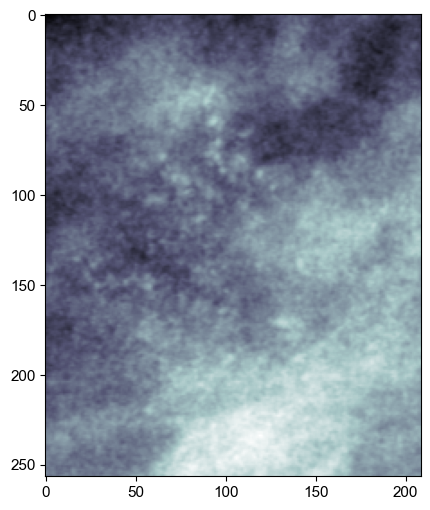

In [22]:
image_path = path_calc_train[23]
ctrain3 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctrain3.pixel_array, cmap="bone")
#plt.colorbar()

print(ctrain3)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.217960512913229945313921169141958704601
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.217960512913229945313921169141958704601
(0008, 0020) Study Date                          DA: '20170830'
(0008, 0023) Content D

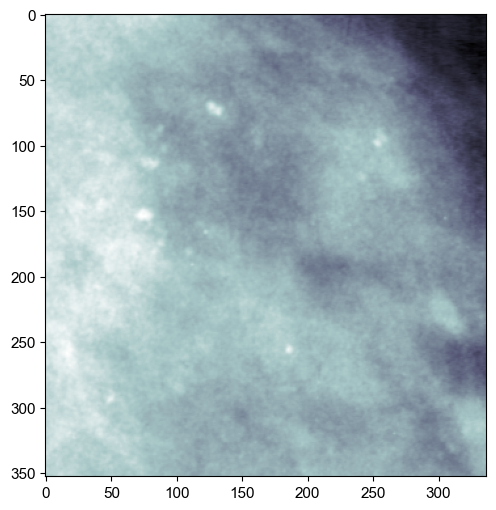

In [23]:
image_path = path_calc_train[34]
ctrain4 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctrain4.pixel_array, cmap="bone")
#plt.colorbar()

print(ctrain4)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.173338537212637308823544308673220823894
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.173338537212637308823544308673220823894
(0008, 0020) Study Date                          DA: '20170829'
(0008, 0023) Content D

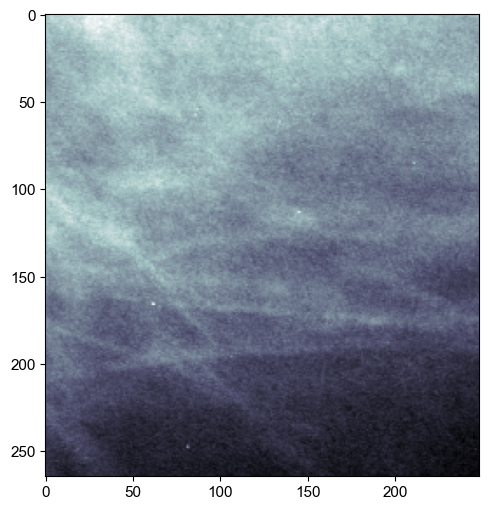

In [24]:
image_path = path_calc_test[1]
ctest = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctest.pixel_array, cmap="bone")
#plt.colorbar()

print(ctest)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.126328265013163294124888165281940914394
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.126328265013163294124888165281940914394
(0008, 0020) Study Date                          DA: '20170829'
(0008, 0023) Content D

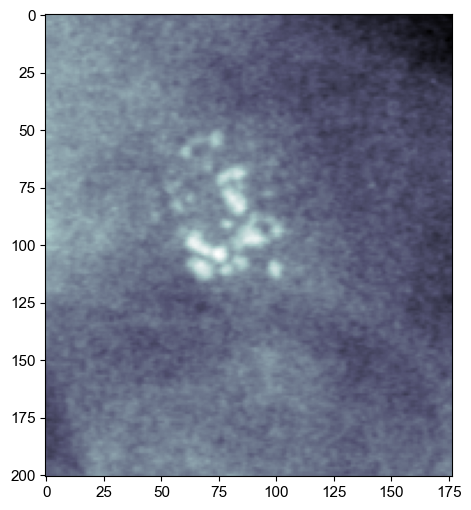

In [25]:
image_path = path_calc_test[12]
ctest2 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctest2.pixel_array, cmap="bone")
#plt.colorbar()

print(ctest2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.397792063810584060901964798782256967640
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.397792063810584060901964798782256967640
(0008, 0020) Study Date                          DA: '20170829'
(0008, 0023) Content D

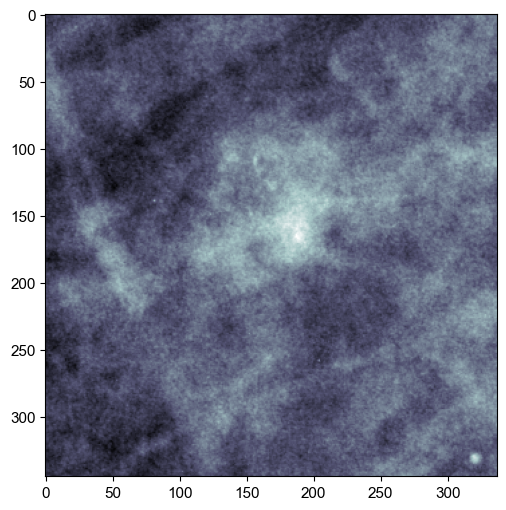

In [26]:
image_path = path_calc_test[23]
ctest3 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctest3.pixel_array, cmap="bone")
#plt.colorbar()

print(ctest3)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.94638674211239918103166767580933085038
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.94638674211239918103166767580933085038
(0008, 0020) Study Date                          DA: '20170829'
(0008, 0023) Content Dat

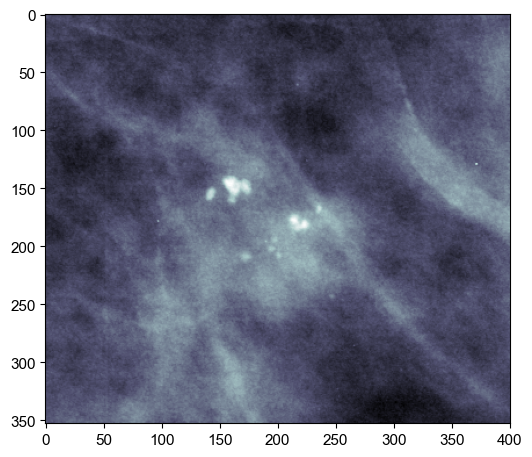

In [27]:
image_path = path_calc_test[34]
ctest4 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(ctest4.pixel_array, cmap="bone")
#plt.colorbar()

print(ctest4)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.194533277513825438327220734753021300752
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.194533277513825438327220734753021300752
(0008, 0020) Study Date                          DA: '20160720'
(0008, 0023) Content D

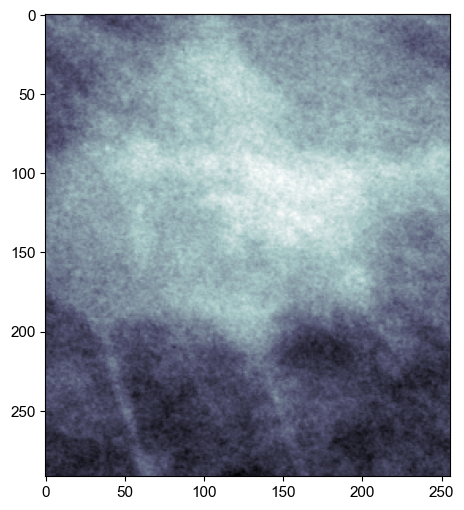

In [28]:
image_path = path_mass_train[1]
mtrain = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtrain.pixel_array, cmap="bone")
#plt.colorbar()

print(mtrain)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.316976183612489195214682494904115419563
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.316976183612489195214682494904115419563
(0008, 0020) Study Date                          DA: '20160720'
(0008, 0023) Content D

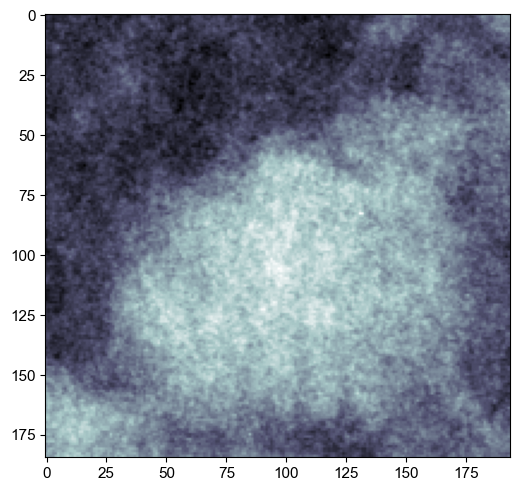

In [29]:
image_path = path_mass_train[12]
mtrain2 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtrain2.pixel_array, cmap="bone")
#plt.colorbar()

print(mtrain2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.338680246613214480240274889342353066372
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.338680246613214480240274889342353066372
(0008, 0020) Study Date                          DA: '20160720'
(0008, 0023) Content D

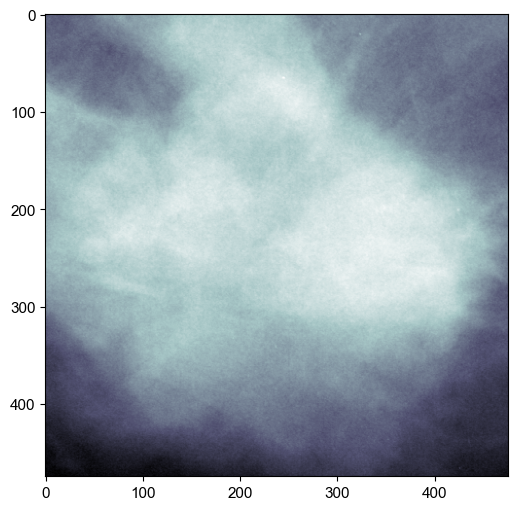

In [30]:
image_path = path_mass_train[23]
mtrain3 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtrain3.pixel_array, cmap="bone")
#plt.colorbar()

print(mtrain3)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.13798197112345490213653344301905863998
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.13798197112345490213653344301905863998
(0008, 0020) Study Date                          DA: '20160720'
(0008, 0023) Content Dat

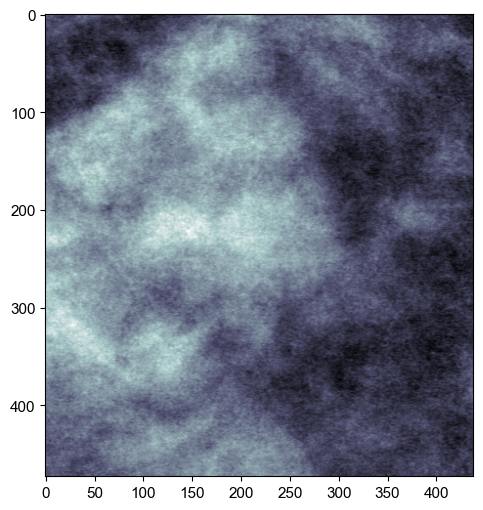

In [31]:
image_path = path_mass_train[35]
mtrain4 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtrain4.pixel_array, cmap="bone")
#plt.colorbar()

print(mtrain4)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.97577222212500948806956394284059526655
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.97577222212500948806956394284059526655
(0008, 0020) Study Date                          DA: '20161004'
(0008, 0023) Content Dat

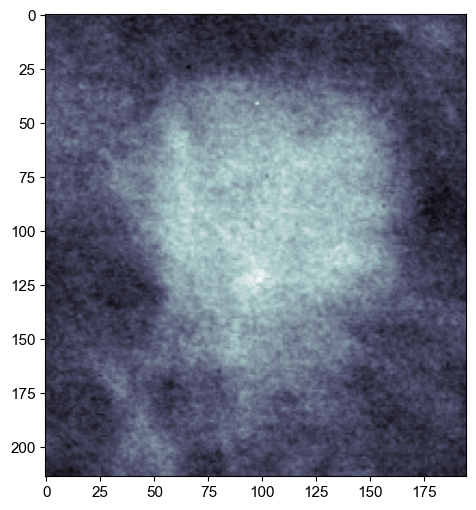

In [32]:
image_path = path_mass_test[2]
mtest = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtest.pixel_array, cmap="bone")
#plt.colorbar()

print(mtest)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.415817896312981914530817978200616515974
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.415817896312981914530817978200616515974
(0008, 0020) Study Date                          DA: '20161004'
(0008, 0023) Content D

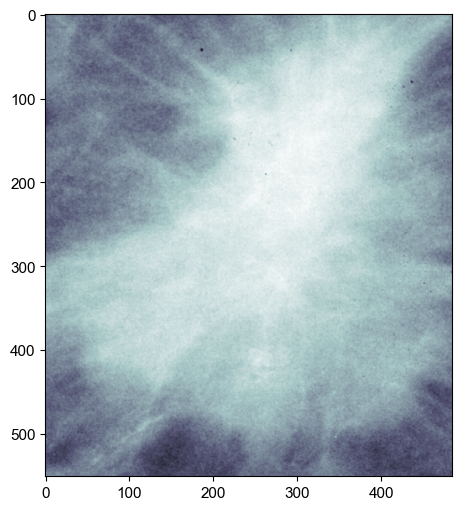

In [33]:
image_path = path_mass_test[13]
mtest2 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtest2.pixel_array, cmap="bone")
#plt.colorbar()

print(mtest2)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.36256180610693044941846901112358390652
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.36256180610693044941846901112358390652
(0008, 0020) Study Date                          DA: '20161004'
(0008, 0023) Content Dat

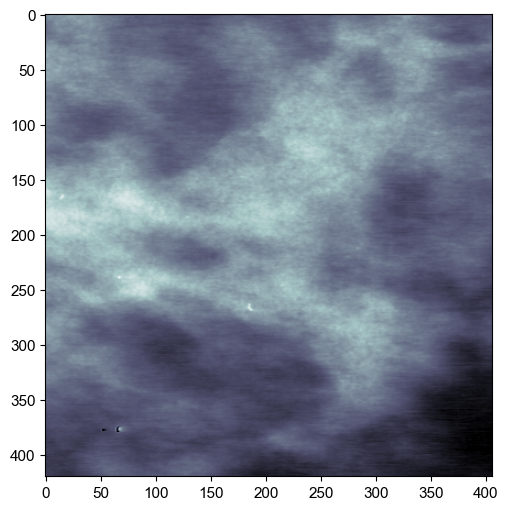

In [34]:
image_path = path_mass_test[24]
mtest3 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtest3.pixel_array, cmap="bone")
#plt.colorbar()

print(mtest3)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.295793992113426488203177947300964893170
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.295793992113426488203177947300964893170
(0008, 0020) Study Date                          DA: '20161004'
(0008, 0023) Content D

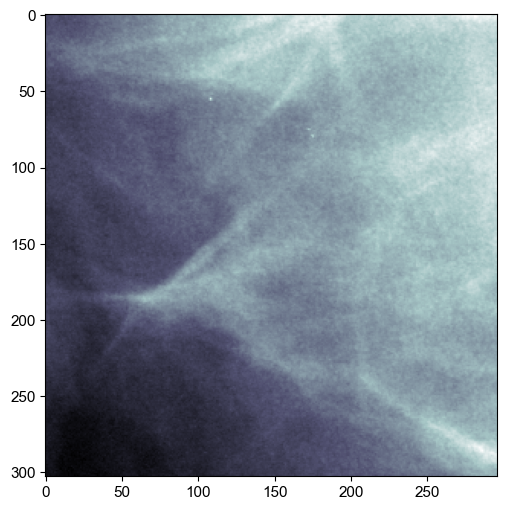

In [35]:
image_path = path_mass_test[35]
mtest4 = dicom.dcmread(image_path)

plt.figure(figsize = (6, 6))
plt.imshow(mtest4.pixel_array, cmap="bone")
#plt.colorbar()

print(mtest4)

### Localizando ids para saber malignidade:

In [36]:
mammography.loc[mammography['patient_id'] == 'P_00005']

patient_id  breast density left or right breast image view  \
257    P_00005             3.0                RIGHT         CC   
258    P_00005             3.0                RIGHT        MLO   

     abnormality id abnormality type  calc type calc distribution  assessment  \
257               1    calcification  AMORPHOUS         CLUSTERED           3   
258               1    calcification  AMORPHOUS         CLUSTERED           3   

     pathology  subtlety                                    image file path  \
257          1         3  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
258          1         3  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   

                               cropped image file path  \
257  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
258  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   

                                    ROI mask file path  breast_density  \
257  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...             NaN   
258  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....             NaN   

    mass shape mass margins  
257        NaN          NaN  
258        NaN          NaN

In [37]:
mammography.loc[mammography['patient_id'] == 'P_00016']

patient_id  breast density left or right breast image view  \
268     P_00016             4.0                 LEFT         CC   
269     P_00016             4.0                 LEFT        MLO   
1322    P_00016             NaN                 LEFT         CC   
1323    P_00016             NaN                 LEFT        MLO   

      abnormality id abnormality type    calc type calc distribution  \
268                2    calcification  PLEOMORPHIC         CLUSTERED   
269                2    calcification  PLEOMORPHIC         CLUSTERED   
1322               1             mass          NaN               NaN   
1323               1             mass          NaN               NaN   

      assessment  pathology  subtlety  \
268            5          1         5   
269            5          1         5   
1322           5          1         5   
1323           5          1         5   

                                        image file path  \
268   Calc-Training_P_00016_LEFT_CC/1.3.6.1.4.1.9590...   
269   Calc-Training_P_00016_LEFT_MLO/1.3.6.1.4.1.959...   
1322  Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...   
1323  Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...   

                                cropped image file path  \
268   Calc-Training_P_00016_LEFT_CC_2/1.3.6.1.4.1.95...   
269   Calc-Training_P_00016_LEFT_MLO_2/1.3.6.1.4.1.9...   
1322  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1323  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   

                                     ROI mask file path  breast_density  \
268   Calc-Training_P_00016_LEFT_CC_2/1.3.6.1.4.1.95...             NaN   
269   Calc-Training_P_00016_LEFT_MLO_2/1.3.6.1.4.1.9...             NaN   
1322  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...             4.0   
1323  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....             4.0   

     mass shape mass margins  
268         NaN          NaN  
269         NaN          NaN  
1322  IRREGULAR   SPICULATED  
1323  IRREGULAR   SPICULATED

In [38]:
mammography.loc[mammography['patient_id'] == 'P_00029']

patient_id  breast density left or right breast image view  \
279    P_00029             3.0                 LEFT         CC   
280    P_00029             3.0                 LEFT        MLO   

     abnormality id abnormality type    calc type calc distribution  \
279               1    calcification  PLEOMORPHIC         CLUSTERED   
280               1    calcification  PLEOMORPHIC         CLUSTERED   

     assessment  pathology  subtlety  \
279           4          1         2   
280           4          1         2   

                                       image file path  \
279  Calc-Training_P_00029_LEFT_CC/1.3.6.1.4.1.9590...   
280  Calc-Training_P_00029_LEFT_MLO/1.3.6.1.4.1.959...   

                               cropped image file path  \
279  Calc-Training_P_00029_LEFT_CC_1/1.3.6.1.4.1.95...   
280  Calc-Training_P_00029_LEFT_MLO_1/1.3.6.1.4.1.9...   

                                    ROI mask file path  breast_density  \
279  Calc-Training_P_00029_LEFT_CC_1/1.3.6.1.4.1.95...             NaN   
280  Calc-Training_P_00029_LEFT_MLO_1/1.3.6.1.4.1.9...             NaN   

    mass shape mass margins  
279        NaN          NaN  
280        NaN          NaN

In [39]:
mammography.loc[mammography['patient_id'] == 'P_00049']

patient_id  breast density left or right breast image view  \
291    P_00049             4.0                RIGHT         CC   
292    P_00049             4.0                RIGHT        MLO   

     abnormality id abnormality type    calc type calc distribution  \
291               1    calcification  PLEOMORPHIC         CLUSTERED   
292               1    calcification  PLEOMORPHIC         CLUSTERED   

     assessment  pathology  subtlety  \
291           4          1         3   
292           4          1         3   

                                       image file path  \
291  Calc-Training_P_00049_RIGHT_CC/1.3.6.1.4.1.959...   
292  Calc-Training_P_00049_RIGHT_MLO/1.3.6.1.4.1.95...   

                               cropped image file path  \
291  Calc-Training_P_00049_RIGHT_CC_1/1.3.6.1.4.1.9...   
292  Calc-Training_P_00049_RIGHT_MLO_1/1.3.6.1.4.1....   

                                    ROI mask file path  breast_density  \
291  Calc-Training_P_00049_RIGHT_CC_1/1.3.6.1.4.1.9...             NaN   
292  Calc-Training_P_00049_RIGHT_MLO_1/1.3.6.1.4.1....             NaN   

    mass shape mass margins  
291        NaN          NaN  
292        NaN          NaN

In [40]:
mammography.loc[mammography['patient_id'] == 'P_00038']

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038             2.0                 LEFT         CC               1   
1    P_00038             2.0                 LEFT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   

   pathology  subtlety                                    image file path  \
0          0         2  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1          0         2  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   

                             cropped image file path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   

                                  ROI mask file path  breast_density  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...             NaN   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....             NaN   

  mass shape mass margins  
0        NaN          NaN  
1        NaN          NaN

In [41]:
mammography.loc[mammography['patient_id'] == 'P_00164']

patient_id  breast density left or right breast image view  abnormality id  \
12    P_00164             4.0                RIGHT         CC               1   

   abnormality type    calc type calc distribution  assessment  pathology  \
12    calcification  PLEOMORPHIC         CLUSTERED           4          1   

    subtlety                                    image file path  \
12         3  Calc-Test_P_00164_RIGHT_CC/1.3.6.1.4.1.9590.10...   

                              cropped image file path  \
12  Calc-Test_P_00164_RIGHT_CC_1/1.3.6.1.4.1.9590....   

                                   ROI mask file path  breast_density  \
12  Calc-Test_P_00164_RIGHT_CC_1/1.3.6.1.4.1.9590....             NaN   

   mass shape mass margins  
12        NaN          NaN

In [42]:
mammography.loc[mammography['patient_id'] == 'P_00257']

patient_id  breast density left or right breast image view  abnormality id  \
22    P_00257             2.0                RIGHT         CC               1   
23    P_00257             2.0                RIGHT        MLO               1   

   abnormality type    calc type calc distribution  assessment  pathology  \
22    calcification  PLEOMORPHIC         CLUSTERED           4          0   
23    calcification  PLEOMORPHIC         CLUSTERED           4          0   

    subtlety                                    image file path  \
22         2  Calc-Test_P_00257_RIGHT_CC/1.3.6.1.4.1.9590.10...   
23         2  Calc-Test_P_00257_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                              cropped image file path  \
22  Calc-Test_P_00257_RIGHT_CC_1/1.3.6.1.4.1.9590....   
23  Calc-Test_P_00257_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                   ROI mask file path  breast_density  \
22  Calc-Test_P_00257_RIGHT_CC_1/1.3.6.1.4.1.9590....             NaN   
23  Calc-Test_P_00257_RIGHT_MLO_1/1.3.6.1.4.1.9590...             NaN   

   mass shape mass margins  
22        NaN          NaN  
23        NaN          NaN

In [43]:
mammography.loc[mammography['patient_id'] == 'P_00352']

patient_id  breast density left or right breast image view  abnormality id  \
33    P_00352             2.0                 LEFT         CC               1   
34    P_00352             2.0                 LEFT        MLO               1   

   abnormality type    calc type calc distribution  assessment  pathology  \
33    calcification  PLEOMORPHIC         CLUSTERED           4          0   
34    calcification  PLEOMORPHIC         CLUSTERED           4          0   

    subtlety                                    image file path  \
33         4  Calc-Test_P_00352_LEFT_CC/1.3.6.1.4.1.9590.100...   
34         5  Calc-Test_P_00352_LEFT_MLO/1.3.6.1.4.1.9590.10...   

                              cropped image file path  \
33  Calc-Test_P_00352_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
34  Calc-Test_P_00352_LEFT_MLO_1/1.3.6.1.4.1.9590....   

                                   ROI mask file path  breast_density  \
33  Calc-Test_P_00352_LEFT_CC_1/1.3.6.1.4.1.9590.1...             NaN   
34  Calc-Test_P_00352_LEFT_MLO_1/1.3.6.1.4.1.9590....             NaN   

   mass shape mass margins  
33        NaN          NaN  
34        NaN          NaN

In [44]:
mammography.loc[mammography['patient_id'] == 'P_00001']

patient_id  breast density left or right breast image view  \
1660    P_00001             NaN                 LEFT         CC   
1661    P_00001             NaN                 LEFT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1660               1             mass       NaN               NaN           4   
1661               1             mass       NaN               NaN           4   

      pathology  subtlety                                    image file path  \
1660          1         4  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1661          1         4  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   

                                cropped image file path  \
1660  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1661  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   

                                     ROI mask file path  breast_density  \
1660  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...             3.0   
1661  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...             3.0   

                              mass shape mass margins  
1660  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED  
1661  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED

In [45]:
mammography.loc[mammography['patient_id'] == 'P_00021']

patient_id  breast density left or right breast image view  \
1670    P_00021             NaN                 LEFT         CC   
1671    P_00021             NaN                 LEFT        MLO   
1672    P_00021             NaN                RIGHT         CC   
1673    P_00021             NaN                RIGHT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1670               1             mass       NaN               NaN           3   
1671               1             mass       NaN               NaN           3   
1672               1             mass       NaN               NaN           3   
1673               1             mass       NaN               NaN           3   

      pathology  subtlety                                    image file path  \
1670          0         5  Mass-Training_P_00021_LEFT_CC/1.3.6.1.4.1.9590...   
1671          0         5  Mass-Training_P_00021_LEFT_MLO/1.3.6.1.4.1.959...   
1672          0         5  Mass-Training_P_00021_RIGHT_CC/1.3.6.1.4.1.959...   
1673          0         5  Mass-Training_P_00021_RIGHT_MLO/1.3.6.1.4.1.95...   

                                cropped image file path  \
1670  Mass-Training_P_00021_LEFT_CC_1/1.3.6.1.4.1.95...   
1671  Mass-Training_P_00021_LEFT_MLO_1/1.3.6.1.4.1.9...   
1672  Mass-Training_P_00021_RIGHT_CC_1/1.3.6.1.4.1.9...   
1673  Mass-Training_P_00021_RIGHT_MLO_1/1.3.6.1.4.1....   

                                     ROI mask file path  breast_density  \
1670  Mass-Training_P_00021_LEFT_CC_1/1.3.6.1.4.1.95...             1.0   
1671  Mass-Training_P_00021_LEFT_MLO_1/1.3.6.1.4.1.9...             1.0   
1672  Mass-Training_P_00021_RIGHT_CC_1/1.3.6.1.4.1.9...             1.0   
1673  Mass-Training_P_00021_RIGHT_MLO_1/1.3.6.1.4.1....             1.0   

     mass shape   mass margins  
1670       OVAL  CIRCUMSCRIBED  
1671       OVAL  CIRCUMSCRIBED  
1672       OVAL  CIRCUMSCRIBED  
1673       OVAL  CIRCUMSCRIBED

In [46]:
mammography.loc[mammography['patient_id'] == 'P_00039']

patient_id  breast density left or right breast image view  \
1682    P_00039             NaN                RIGHT         CC   
1683    P_00039             NaN                RIGHT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1682               1             mass       NaN               NaN           5   
1683               1             mass       NaN               NaN           5   

      pathology  subtlety                                    image file path  \
1682          1         5  Mass-Training_P_00039_RIGHT_CC/1.3.6.1.4.1.959...   
1683          1         5  Mass-Training_P_00039_RIGHT_MLO/1.3.6.1.4.1.95...   

                                cropped image file path  \
1682  Mass-Training_P_00039_RIGHT_CC_1/1.3.6.1.4.1.9...   
1683  Mass-Training_P_00039_RIGHT_MLO_1/1.3.6.1.4.1....   

                                     ROI mask file path  breast_density  \
1682  Mass-Training_P_00039_RIGHT_CC_1/1.3.6.1.4.1.9...             2.0   
1683  Mass-Training_P_00039_RIGHT_MLO_1/1.3.6.1.4.1....             2.0   

     mass shape mass margins  
1682  IRREGULAR   SPICULATED  
1683  IRREGULAR   SPICULATED

In [47]:
mammography.loc[mammography['patient_id'] == 'P_00055']

patient_id  breast density left or right breast image view  \
1695    P_00055             NaN                 LEFT         CC   

      abnormality id abnormality type calc type calc distribution  assessment  \
1695               1             mass       NaN               NaN           0   

      pathology  subtlety                                    image file path  \
1695          0         3  Mass-Training_P_00055_LEFT_CC/1.3.6.1.4.1.9590...   

                                cropped image file path  \
1695  Mass-Training_P_00055_LEFT_CC_1/1.3.6.1.4.1.95...   

                                     ROI mask file path  breast_density  \
1695  Mass-Training_P_00055_LEFT_CC_1/1.3.6.1.4.1.95...             2.0   

     mass shape   mass margins  
1695  LOBULATED  CIRCUMSCRIBED

In [48]:
mammography.loc[mammography['patient_id'] == 'P_00017']

patient_id  breast density left or right breast image view  \
1324    P_00017             NaN                 LEFT         CC   
1325    P_00017             NaN                 LEFT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1324               1             mass       NaN               NaN           4   
1325               1             mass       NaN               NaN           4   

      pathology  subtlety                                    image file path  \
1324          1         4  Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...   
1325          1         4  Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...   

                                cropped image file path  \
1324  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1325  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   

                                     ROI mask file path  breast_density  \
1324  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...             2.0   
1325  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....             2.0   

     mass shape   mass margins  
1324      ROUND  CIRCUMSCRIBED  
1325      ROUND    ILL_DEFINED

In [49]:
mammography.loc[mammography['patient_id'] == 'P_00116']

patient_id  breast density left or right breast image view  \
1334    P_00116             NaN                RIGHT         CC   
1335    P_00116             NaN                RIGHT         CC   
1336    P_00116             NaN                RIGHT        MLO   
1337    P_00116             NaN                RIGHT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1334               1             mass       NaN               NaN           5   
1335               2             mass       NaN               NaN           5   
1336               1             mass       NaN               NaN           5   
1337               2             mass       NaN               NaN           5   

      pathology  subtlety                                    image file path  \
1334          1         5  Mass-Test_P_00116_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1335          1         5  Mass-Test_P_00116_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1336          1         5  Mass-Test_P_00116_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1337          1         5  Mass-Test_P_00116_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                                cropped image file path  \
1334  Mass-Test_P_00116_RIGHT_CC_1/1.3.6.1.4.1.9590....   
1335  Mass-Test_P_00116_RIGHT_CC_2/1.3.6.1.4.1.9590....   
1336  Mass-Test_P_00116_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1337  Mass-Test_P_00116_RIGHT_MLO_2/1.3.6.1.4.1.9590...   

                                     ROI mask file path  breast_density  \
1334  Mass-Test_P_00116_RIGHT_CC_1/1.3.6.1.4.1.9590....             2.0   
1335  Mass-Test_P_00116_RIGHT_CC_2/1.3.6.1.4.1.9590....             2.0   
1336  Mass-Test_P_00116_RIGHT_MLO_1/1.3.6.1.4.1.9590...             2.0   
1337  Mass-Test_P_00116_RIGHT_MLO_2/1.3.6.1.4.1.9590...             2.0   

                              mass shape mass margins  
1334  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED  
1335  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED  
1336  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED  
1337  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED

In [50]:
mammography.loc[mammography['patient_id'] == 'P_00145']

patient_id  breast density left or right breast image view  \
1345    P_00145             NaN                 LEFT         CC   
1346    P_00145             NaN                 LEFT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1345               1             mass       NaN               NaN           0   
1346               1             mass       NaN               NaN           0   

      pathology  subtlety                                    image file path  \
1345          0         4  Mass-Test_P_00145_LEFT_CC/1.3.6.1.4.1.9590.100...   
1346          0         4  Mass-Test_P_00145_LEFT_MLO/1.3.6.1.4.1.9590.10...   

                                cropped image file path  \
1345  Mass-Test_P_00145_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1346  Mass-Test_P_00145_LEFT_MLO_1/1.3.6.1.4.1.9590....   

                                     ROI mask file path  breast_density  \
1345  Mass-Test_P_00145_LEFT_CC_1/1.3.6.1.4.1.9590.1...             3.0   
1346  Mass-Test_P_00145_LEFT_MLO_1/1.3.6.1.4.1.9590....             3.0   

     mass shape mass margins  
1345       OVAL     OBSCURED  
1346       OVAL     OBSCURED

In [51]:
mammography.loc[mammography['patient_id'] == 'P_00173']

patient_id  breast density left or right breast image view  \
1352    P_00173             NaN                 LEFT         CC   
1353    P_00173             NaN                 LEFT        MLO   
1354    P_00173             NaN                RIGHT         CC   
1355    P_00173             NaN                RIGHT         CC   
1356    P_00173             NaN                RIGHT        MLO   
1357    P_00173             NaN                RIGHT        MLO   

      abnormality id abnormality type calc type calc distribution  assessment  \
1352               1             mass       NaN               NaN           3   
1353               1             mass       NaN               NaN           3   
1354               1             mass       NaN               NaN           3   
1355               2             mass       NaN               NaN           3   
1356               1             mass       NaN               NaN           3   
1357               2             mass       NaN               NaN           3   

      pathology  subtlety                                    image file path  \
1352          0         5  Mass-Test_P_00173_LEFT_CC/1.3.6.1.4.1.9590.100...   
1353          0         5  Mass-Test_P_00173_LEFT_MLO/1.3.6.1.4.1.9590.10...   
1354          0         5  Mass-Test_P_00173_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1355          0         5  Mass-Test_P_00173_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1356          0         5  Mass-Test_P_00173_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1357          0         4  Mass-Test_P_00173_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                                cropped image file path  \
1352  Mass-Test_P_00173_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1353  Mass-Test_P_00173_LEFT_MLO_1/1.3.6.1.4.1.9590....   
1354  Mass-Test_P_00173_RIGHT_CC_1/1.3.6.1.4.1.9590....   
1355  Mass-Test_P_00173_RIGHT_CC_2/1.3.6.1.4.1.9590....   
1356  Mass-Test_P_00173_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1357  Mass-Test_P_00173_RIGHT_MLO_2/1.3.6.1.4.1.9590...   

                                     ROI mask file path  breast_density  \
1352  Mass-Test_P_00173_LEFT_CC_1/1.3.6.1.4.1.9590.1...             2.0   
1353  Mass-Test_P_00173_LEFT_MLO_1/1.3.6.1.4.1.9590....             2.0   
1354  Mass-Test_P_00173_RIGHT_CC_1/1.3.6.1.4.1.9590....             2.0   
1355  Mass-Test_P_00173_RIGHT_CC_2/1.3.6.1.4.1.9590....             2.0   
1356  Mass-Test_P_00173_RIGHT_MLO_1/1.3.6.1.4.1.9590...             2.0   
1357  Mass-Test_P_00173_RIGHT_MLO_2/1.3.6.1.4.1.9590...             2.0   

     mass shape   mass margins  
1352  LOBULATED  CIRCUMSCRIBED  
1353  LOBULATED  CIRCUMSCRIBED  
1354       OVAL  CIRCUMSCRIBED  
1355  LOBULATED  CIRCUMSCRIBED  
1356       OVAL  CIRCUMSCRIBED  
1357  LOBULATED  CIRCUMSCRIBED

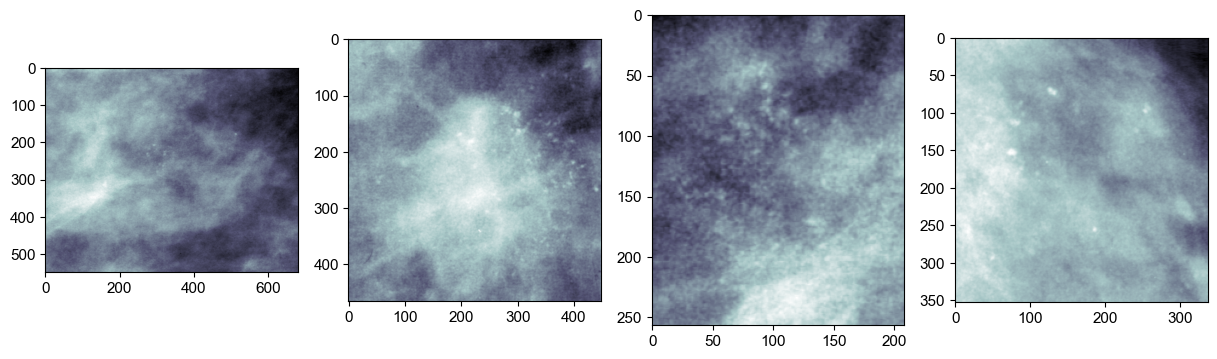

In [52]:
plt.figure(1, figsize = (15, 5))
plt.rc('font', family = 'Arial', size = 11)
plt.subplot(1, 4, 1) 
plt.imshow(ctrain.pixel_array, cmap="bone")
plt.subplot(1, 4, 2) 
plt.imshow(ctrain2.pixel_array, cmap="bone")
plt.subplot(1, 4, 3) 
plt.imshow(ctrain3.pixel_array, cmap="bone")
plt.subplot(1, 4, 4) 
plt.imshow(ctrain4.pixel_array, cmap="bone")
plt.show()

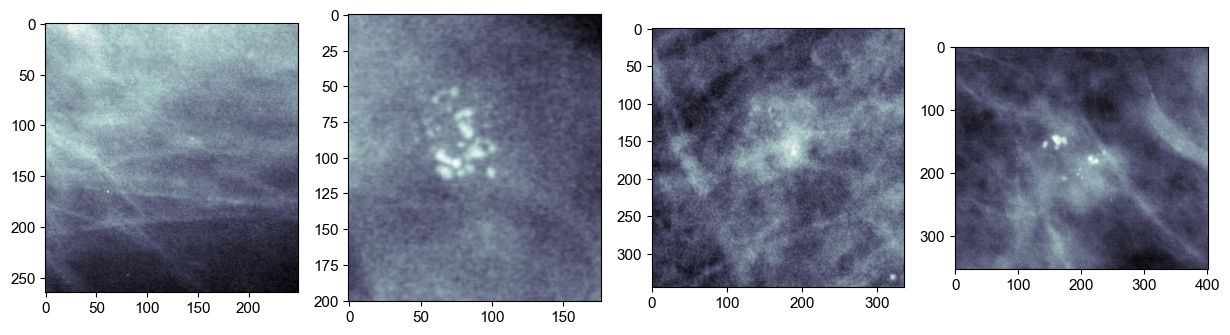

In [53]:
plt.figure(1, figsize = (15, 5))
plt.rc('font', family = 'Arial', size = 11)
plt.subplot(1, 4, 1) 
plt.imshow(ctest.pixel_array, cmap="bone")
plt.subplot(1, 4, 2) 
plt.imshow(ctest2.pixel_array, cmap="bone")
plt.subplot(1, 4, 3) 
plt.imshow(ctest3.pixel_array, cmap="bone")
plt.subplot(1, 4, 4) 
plt.imshow(ctest4.pixel_array, cmap="bone")
plt.show()

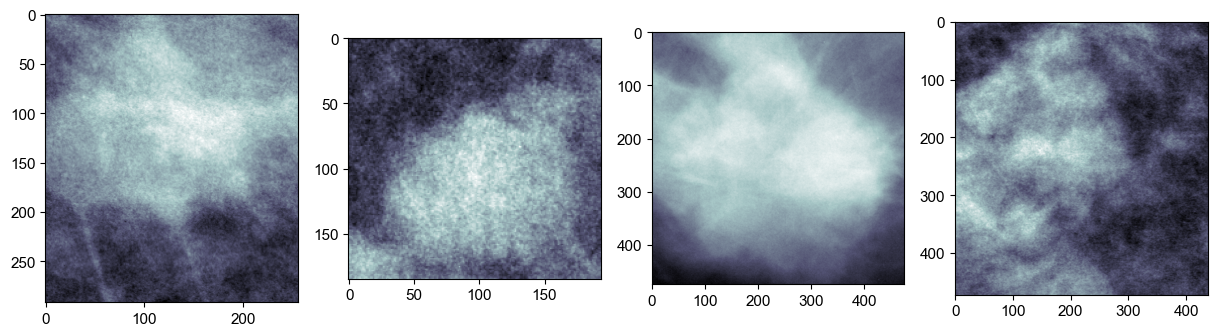

In [54]:
plt.figure(1, figsize = (15, 5))
plt.rc('font', family = 'Arial', size = 11)
plt.subplot(1, 4, 1) 
plt.imshow(mtrain.pixel_array, cmap="bone")
plt.subplot(1, 4, 2) 
plt.imshow(mtrain2.pixel_array, cmap="bone")
plt.subplot(1, 4, 3) 
plt.imshow(mtrain3.pixel_array, cmap="bone")
plt.subplot(1, 4, 4) 
plt.imshow(mtrain4.pixel_array, cmap="bone")
plt.show()

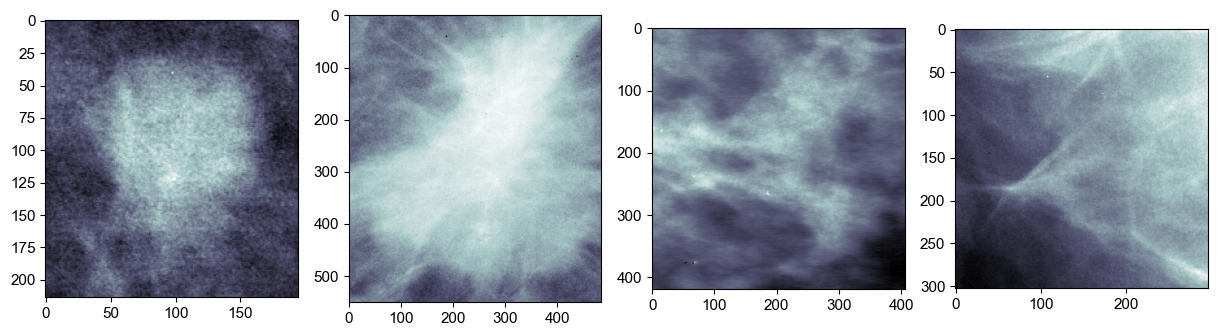

In [55]:
plt.figure(1, figsize = (15, 5))
plt.rc('font', family = 'Arial', size = 11)
plt.subplot(1, 4, 1) 
plt.imshow(mtest.pixel_array, cmap="bone")
plt.subplot(1, 4, 2) 
plt.imshow(mtest2.pixel_array, cmap="bone")
plt.subplot(1, 4, 3) 
plt.imshow(mtest3.pixel_array, cmap="bone")
plt.subplot(1, 4, 4) 
plt.imshow(mtest4.pixel_array, cmap="bone")
plt.show()

In [56]:
print(len(path_calc_test), len(path_calc_train), len(path_mass_test), len(path_mass_train))

257 1065 338 1196


In [57]:
calc_tr['paths'] = path_calc_train
calc_te['paths'] = path_calc_test
mass_tr['paths'] = path_mass_train
mass_te['paths'] = path_mass_test

patho_calc_train = calc_tr['pathology'].tolist()
patho_calc_test = calc_te['pathology'].tolist()
patho_mass_train = mass_tr['pathology'].tolist()
patho_mass_test = mass_te['pathology'].tolist()

In [58]:
#Reduzindo os conjuntos de treino e teste 75% e 25% 
calc_train = calc_tr.iloc[0:600]
calc_test = calc_te.iloc[0:200]
mass_train = mass_tr.iloc[0:600]
mass_test = mass_te.iloc[0:200]

pathology_calc_train = patho_calc_train[0:600]
pathology_calc_test = patho_calc_test[0:200]
pathology_mass_train = patho_mass_train[0:600]
pathology_mass_test = patho_mass_test[0:200]

calc_train_list = calc_train['paths'].tolist()
calc_test_list = calc_test['paths'].tolist()
mass_train_list = mass_train['paths'].tolist()
mass_test_list = mass_test['paths'].tolist()

# Pré processamento das imagens

In [59]:
X_calc_train, y_calc_train, X_mass_train, y_mass_train = [], [], [], []
X_calc_test, y_calc_test, X_mass_test, y_mass_test = [], [], [], []

In [60]:
def resize_img(pixels): 
    return resize(pixels, (256, 256), anti_aliasing = True).astype(float)

In [61]:
for elem in calc_test_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_calc_test.append(pixels)
    
for elem in calc_train_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_calc_train.append(pixels)
    
for elem in mass_test_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_mass_test.append(pixels)
    
for elem in mass_train_list:
    img = dicom.dcmread(elem)
    pixels = resize_img(img.pixel_array)
    X_mass_train.append(pixels)

In [62]:
for elem in pathology_calc_test:
    y_calc_test.append(elem)
    
for elem in pathology_calc_train:
    y_calc_train.append(elem)
    
for elem in pathology_mass_test:
    y_mass_test.append(elem)
    
for elem in pathology_mass_train:
    y_mass_train.append(elem)

In [63]:
X_calc_train = np.asarray(X_calc_train)
X_calc_test = np.asarray(X_calc_test)
X_mass_train = np.asarray(X_mass_train)
X_mass_test = np.asarray(X_mass_test)

y_calc_train = np.asarray(y_calc_train)
y_calc_test = np.asarray(y_calc_test)
y_mass_train = np.asarray(y_mass_train)
y_mass_test = np.asarray(y_mass_test)

X_calc_train = gray2rgb(X_calc_train)
X_calc_test = gray2rgb(X_calc_test)
X_mass_train = gray2rgb(X_mass_train)
X_mass_test = gray2rgb(X_mass_test)

# Modelo

In [64]:
def Build_CNN_Model(X_train):
    model = Sequential()

    model.add(Conv2D(64, kernel_size = 7, padding = 'same', activation = "relu", input_shape = X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(4, 4))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size = 5, padding = 'same',  activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3, 3))
    model.add(Dropout(0.3))
   
    model.add(Conv2D(64, kernel_size = 3, padding = 'same', strides = (2, 2), activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.5))

    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(48, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    
    model.summary()
    
    opt = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [65]:
def Train_CNN_Model(model, X_train, y_train, X_test, y_test):

    #Dividindo em treino e validação
    #X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size = 0.25, random_state = 42)
    
    mean, std = X_train.mean(), X_train.std()
    X_train, X_test = (X_train - mean)/std, (X_test - mean)/std # normalize data
    
    
    history = model.fit(X_train, y_train, batch_size = 64, epochs = 300, verbose = 1, 
                            validation_data = (X_test, y_test))
    

    plt.rc('font', family = 'Arial', size = 11)
    plt.plot(history.history['accuracy'], color = "darkorange")
    plt.plot(history.history['val_accuracy'], color = "midnightblue")
    plt.title('Acurácia do Modelo 1')
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.show()
    

    plt.rc('font', family = 'Arial', size = 11)
    plt.plot(history.history['loss'], color = "darkorange")
    plt.plot(history.history['val_loss'], color = "midnightblue")
    plt.title('Perda do Modelo 1')
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.show()


In [66]:
model = Build_CNN_Model(X_calc_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        2

Epoch 1/300
10/10 [==============================] - 81s 8s/step - loss: 0.8307 - accuracy: 0.5117 - val_loss: 0.8443 - val_accuracy: 0.4750
Epoch 2/300
10/10 [==============================] - 74s 7s/step - loss: 0.7188 - accuracy: 0.5700 - val_loss: 0.8276 - val_accuracy: 0.4700
Epoch 3/300
10/10 [==============================] - 66s 6s/step - loss: 0.6957 - accuracy: 0.5600 - val_loss: 0.7413 - val_accuracy: 0.4750
Epoch 4/300
10/10 [==============================] - 75s 7s/step - loss: 0.6856 - accuracy: 0.5900 - val_loss: 0.7045 - val_accuracy: 0.5150
Epoch 5/300
10/10 [==============================] - 74s 7s/step - loss: 0.6935 - accuracy: 0.5667 - val_loss: 0.6928 - val_accuracy: 0.5450
Epoch 6/300
10/10 [==============================] - 71s 7s/step - loss: 0.6721 - accuracy: 0.5783 - val_loss: 0.6975 - val_accuracy: 0.5400
Epoch 7/300
10/10 [==============================] - 70s 7s/step - loss: 0.6817 - accuracy: 0.5900 - val_loss: 0.6904 - val_accuracy: 0.5500
Epoch 8/300
1

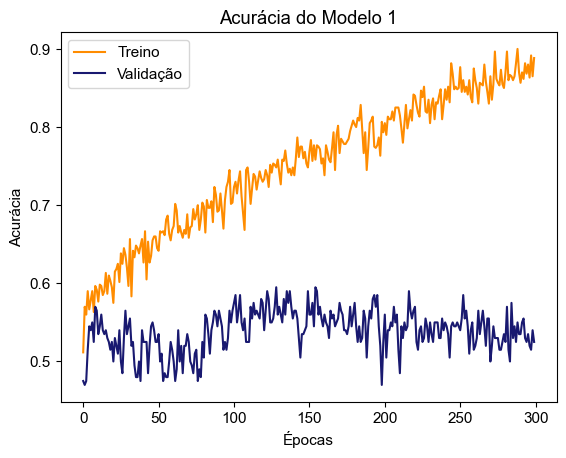

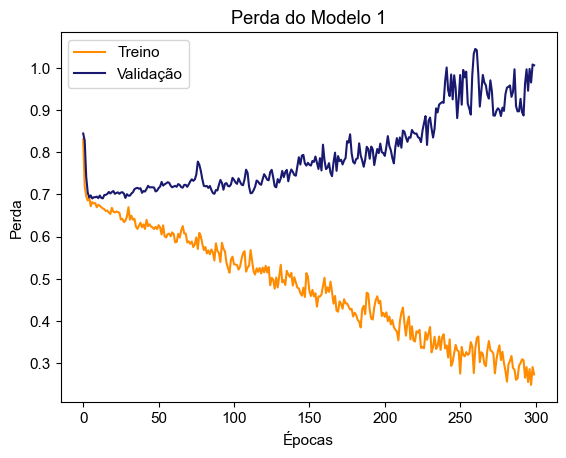

In [67]:
Train_CNN_Model(model, X_calc_train, y_calc_train, X_calc_test, y_calc_test)

In [68]:
model.save('mammography_cnn_calc.h5')

c:\Users\dsrre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
model2 = Build_CNN_Model(X_mass_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      9472      
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)       

Epoch 1/300
10/10 [==============================] - 55s 5s/step - loss: 1.3840 - accuracy: 0.5017 - val_loss: 0.7462 - val_accuracy: 0.4650
Epoch 2/300
10/10 [==============================] - 52s 5s/step - loss: 0.7939 - accuracy: 0.5167 - val_loss: 0.8101 - val_accuracy: 0.4600
Epoch 3/300
10/10 [==============================] - 52s 5s/step - loss: 0.7542 - accuracy: 0.5233 - val_loss: 0.8871 - val_accuracy: 0.4300
Epoch 4/300
10/10 [==============================] - 52s 5s/step - loss: 0.7372 - accuracy: 0.4700 - val_loss: 0.8393 - val_accuracy: 0.4350
Epoch 5/300
10/10 [==============================] - 51s 5s/step - loss: 0.7032 - accuracy: 0.5283 - val_loss: 0.8429 - val_accuracy: 0.4150
Epoch 6/300
10/10 [==============================] - 51s 5s/step - loss: 0.7267 - accuracy: 0.4833 - val_loss: 0.8031 - val_accuracy: 0.4200
Epoch 7/300
10/10 [==============================] - 51s 5s/step - loss: 0.6967 - accuracy: 0.5200 - val_loss: 0.8041 - val_accuracy: 0.4200
Epoch 8/300
1

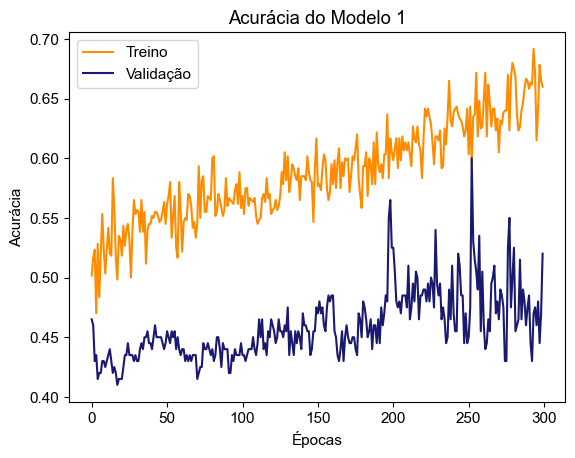

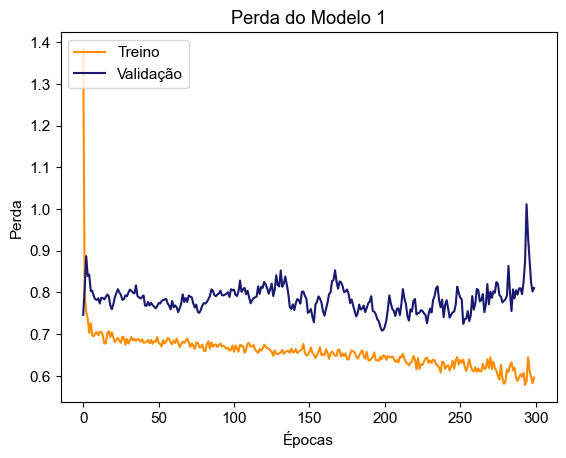

In [70]:
Train_CNN_Model(model2, X_mass_train, y_mass_train, X_mass_test, y_mass_test)

In [71]:
model2.save('mammography_cnn_mass.h5')

# Avaliação do modelo

In [72]:
y_calc = model.predict(X_calc_test)
y_mass = model2.predict(X_mass_test)

7/7 [==============================] - 4s 489ms/step


In [73]:
print(y_calc_test)

[0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1]


In [74]:
print(y_calc)

[[0.48947087]
 [0.39882338]
 [0.4539971 ]
 [0.52071226]
 [0.4422934 ]
 [0.51087505]
 [0.4321739 ]
 [0.4065509 ]
 [0.4663872 ]
 [0.4382885 ]
 [0.52071226]
 [0.5193629 ]
 [0.4641434 ]
 [0.3210279 ]
 [0.37639222]
 [0.2817101 ]
 [0.38434282]
 [0.4212764 ]
 [0.24943295]
 [0.3489021 ]
 [0.4397685 ]
 [0.3970655 ]
 [0.52071226]
 [0.47903368]
 [0.2867814 ]
 [0.46846935]
 [0.42314416]
 [0.5164948 ]
 [0.52071226]
 [0.48024184]
 [0.43749103]
 [0.5020121 ]
 [0.48836175]
 [0.4825837 ]
 [0.44956452]
 [0.49257287]
 [0.45663282]
 [0.38572767]
 [0.42213148]
 [0.5027204 ]
 [0.30411494]
 [0.42109486]
 [0.36501864]
 [0.52071226]
 [0.3661394 ]
 [0.4168657 ]
 [0.26492104]
 [0.3424249 ]
 [0.35617435]
 [0.27258438]
 [0.49952084]
 [0.48060945]
 [0.44565657]
 [0.40720516]
 [0.25730896]
 [0.44658417]
 [0.44669637]
 [0.4917959 ]
 [0.48335436]
 [0.41917336]
 [0.32423845]
 [0.51626366]
 [0.5203237 ]
 [0.3342864 ]
 [0.47546747]
 [0.20025189]
 [0.38294336]
 [0.35420766]
 [0.44226876]
 [0.18100959]
 [0.22526516]
 [0.45

In [75]:
y_calc = [1 if x[0]>0.7 else 0 for x in y_calc]
print(y_calc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [76]:
print(y_mass_test)

[1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [77]:
print(y_mass)

[[0.02287144]
 [0.01653519]
 [0.04711005]
 [0.04820081]
 [0.04086142]
 [0.04215471]
 [0.01722021]
 [0.04461204]
 [0.0795205 ]
 [0.02138705]
 [0.3166794 ]
 [0.0564152 ]
 [0.6764055 ]
 [0.02942154]
 [0.50731105]
 [0.06116778]
 [0.06100903]
 [0.03651197]
 [0.0556337 ]
 [0.03887869]
 [0.0308777 ]
 [0.05716705]
 [0.02966504]
 [0.01754104]
 [0.03224058]
 [0.04016555]
 [0.04158535]
 [0.02138088]
 [0.03832028]
 [0.03676214]
 [0.03157753]
 [0.06022169]
 [0.03214175]
 [0.36966443]
 [0.10680799]
 [0.52476   ]
 [0.0320687 ]
 [0.03837566]
 [0.16366215]
 [0.62272286]
 [0.6490516 ]
 [0.01786075]
 [0.04637904]
 [0.03773582]
 [0.04251782]
 [0.02779379]
 [0.0250096 ]
 [0.04328536]
 [0.06325203]
 [0.39586112]
 [0.04030704]
 [0.04124467]
 [0.06984751]
 [0.05588029]
 [0.04686542]
 [0.08201437]
 [0.05341611]
 [0.35363987]
 [0.05131306]
 [0.06288798]
 [0.04733352]
 [0.04662013]
 [0.04249143]
 [0.0395901 ]
 [0.20205277]
 [0.04436614]
 [0.10715652]
 [0.31924295]
 [0.04246365]
 [0.04747574]
 [0.04835476]
 [0.04

In [78]:
y_mass = [1 if x[0]>0.7 else 0 for x in y_mass]
print(y_mass)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [79]:
target = ["0","1"]
print('Accuracy:', np.round(metrics.accuracy_score(y_calc_test, y_calc),4))
print('Precision:', np.round(metrics.precision_score(y_calc_test, y_calc, average = 'weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_calc_test,y_calc, average = 'weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_calc_test, y_calc, average = 'weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_calc_test, y_calc, multi_class = 'ovo', average = 'weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_calc_test, y_calc),4))
print('\t\tCalc Classification Report:\n', metrics.classification_report(y_calc_test, y_calc, target_names = target))

Accuracy: 0.52
Precision: 0.2744
Recall: 0.52
F1 Score: 0.3592
ROC AUC Score: 0.4952
Cohen Kappa Score: -0.01
		Calc Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       105
           1       0.00      0.00      0.00        95

    accuracy                           0.52       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.27      0.52      0.36       200



In [80]:
print('Accuracy:', np.round(metrics.accuracy_score(y_mass_test, y_mass),4))
print('Precision:', np.round(metrics.precision_score(y_mass_test, y_mass, average = 'weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_mass_test,y_mass, average = 'weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_mass_test, y_mass, average = 'weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_mass_test, y_mass, multi_class = 'ovo', average = 'weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_mass_test, y_mass),4))
print('\t\tMass Classification Report:\n', metrics.classification_report(y_mass_test, y_mass, target_names = target))

Accuracy: 0.575
Precision: 0.3306
Recall: 0.575
F1 Score: 0.4198
ROC AUC Score: 0.5
Cohen Kappa Score: 0.0
		Mass Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       115
           1       0.00      0.00      0.00        85

    accuracy                           0.57       200
   macro avg       0.29      0.50      0.37       200
weighted avg       0.33      0.57      0.42       200



c:\Users\dsrre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsrre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsrre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms